In [1]:
import numpy as np
import csv
import time
import math
import pandas as pd
from numba import cuda, float32, float64
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
from numba import cuda
random.seed(1)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read csv (comma separated value) into data
data = pd.read_csv('housing.csv')

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# checking the null values
data.isnull().sum()
data['total_bedrooms']=data['total_bedrooms'].fillna(0)

In [5]:
data.to_csv('housing_out.csv') 

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

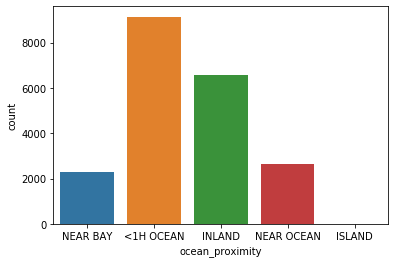

In [6]:
sns.countplot(x="ocean_proximity", data=data)
data.loc[:,'ocean_proximity'].value_counts()

In [7]:
def readData(file):
    file=open(file, 'r')
    reader=csv.reader(file)
    data= []
    for line in reader:
        data.append(line)
    data=np.array(data)
    return data

In [8]:
#Computes wT*x[i] ( the predicted value for datum)
def H(x,w,i):
    sum=0
    for j in range(len(x[0])):
        sum+=x[i][j]*w[j]
    return sum 

In [9]:
def forward_prop(x, weights):
    weights2=weights[n_inputs*n_hidden:]
    z3=0
    #Pass data from the initial layer to the hidden neurons
    for j in range(0,n_hidden-1):
        weights1=weights[n_inputs*j:n_inputs*(j+1)]
        result=0
        for k in range(0,n_inputs):
            result+=(x[k]*weights1[k])
            #result+=0.1
        #Activation function ReLu
        #result=max(0, result)
        #We can add what each hidden neuron contributes to the output layer
        z3+=result*weights2[j]
    #We add the bias
    z3+=weights2[n_hidden-1]
    return z3

In [10]:
#Function for calculating the error
def forward_propagation_Error(x,y,w):
    E=0
    for i in range(0, len(x)):
        wx=0
        wx=forward_prop(x[i], w)
        E+=((wx-y[i][0])**2)
    E=E/len(x)
    return E

In [11]:
class Particle:
    def __init__(self, position, initial_fitness):
         # particles position
        self.particle_position = position
        #initial value of the particle (infinity or minus infinity,
        #depending on whether we want to maximize or minimize)
        self.fitness_particle_position = initial_fitness
        # best position of the particle
        self.local_best_particle_position = []  
        #best initial value of the particle (infinity or minus infinity, 
        #depending on whether we want to maximize or minimize)
        self.fitness_local_best_particle_position = initial_fitness  
        # particle's velocity
        self.particle_velocity = []  
        for i in range(0,num_dimensions):
            #we generate the initial velocity randomly
            self.particle_velocity.append(random.uniform(-vMax, vMax))  
 
    def evaluate(self, x, y, mm):
        self.fitness_particle_position = forward_propagation_Error(x, y, self.particle_position)
        if mm == -1:
            if self.fitness_particle_position < self.fitness_local_best_particle_position:
                # We update the best local position
                self.local_best_particle_position = self.particle_position  
                # We update the best local value 
                self.fitness_local_best_particle_position = self.fitness_particle_position          
        if mm == 1:
            if self.fitness_particle_position > self.fitness_local_best_particle_position:
                 # We update the best local position
                self.local_best_particle_position = self.particle_position  
                # We update the best local value 
                self.fitness_local_best_particle_position = self.fitness_particle_position   
    def update_velocity(self, global_best_particle_position, w, Vmax, c1=2.8, c2=1.3):
        for i in range(0,num_dimensions):
            r1 = random.random()
            r2 = random.random()
            #We calculate the new velocity
            self.particle_velocity[i] = w * self.particle_velocity[i] + c1 * r1 * (self.local_best_particle_position[i] - self.particle_position[i]) + c2 * r2 * (global_best_particle_position[i] - self.particle_position[i])
            
            #We limit the maxmum velocity
            if(self.particle_velocity[i]>Vmax):
                self.particle_velocity[i]=Vmax
            if(self.particle_velocity[i]<-Vmax):
                self.particle_velocity[i]=-Vmax
 
    def update_position(self, bounds):
        for i in range(0,num_dimensions):
            self.particle_position[i] = self.particle_position[i] + self.particle_velocity[i]
 
            #if it reaches the edges, it stays within, it does not exceed the limits
            if self.particle_position[i] > bounds[1]:
                self.particle_position[i] = bounds[1]
            if self.particle_position[i] < bounds[0]:
                self.particle_position[i] = bounds[0]

In [12]:
#PS0 parameters
num_iters=1000
num_particles=500
c1=2.8
c2=1.3
factor=10
Fi=c1+c2
Xi=2/(abs(2-Fi-math.sqrt(abs(Fi**2-4*Fi))))
data=readData('housing_out.csv')
print('Data prior removing',data)

Data prior removing [['' 'longitude' 'latitude' ... 'median_income' 'median_house_value'
  'ocean_proximity']
 ['0' '-122.23' '37.88' ... '8.3252' '452600.0' 'NEAR BAY']
 ['1' '-122.22' '37.86' ... '8.3014' '358500.0' 'NEAR BAY']
 ...
 ['20637' '-121.22' '39.43' ... '1.7' '92300.0' 'INLAND']
 ['20638' '-121.32' '39.43' ... '1.8672' '84700.0' 'INLAND']
 ['20639' '-121.24' '39.37' ... '2.3886' '89400.0' 'INLAND']]


In [13]:
#We remove the first row of names and the last column
data=data[1:10,2:10]
print('Data after removing \n',data)

Data after removing 
 [['37.88' '41.0' '880.0' '129.0' '322.0' '126.0' '8.3252' '452600.0']
 ['37.86' '21.0' '7099.0' '1106.0' '2401.0' '1138.0' '8.3014' '358500.0']
 ['37.85' '52.0' '1467.0' '190.0' '496.0' '177.0' '7.2574' '352100.0']
 ['37.85' '52.0' '1274.0' '235.0' '558.0' '219.0' '5.6431' '341300.0']
 ['37.85' '52.0' '1627.0' '280.0' '565.0' '259.0' '3.8462' '342200.0']
 ['37.85' '52.0' '919.0' '213.0' '413.0' '193.0' '4.0368' '269700.0']
 ['37.84' '52.0' '2535.0' '489.0' '1094.0' '514.0' '3.6591' '299200.0']
 ['37.84' '52.0' '3104.0' '687.0' '1157.0' '647.0' '3.12' '241400.0']
 ['37.84' '42.0' '2555.0' '665.0' '1206.0' '595.0' '2.0804' '226700.0']]


In [14]:
# We preprocess the data
datosPandas=pd.DataFrame(data)
datosPandas

,0,1,2,3,4,5,6,7
0,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
5,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0
6,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0
7,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,241400.0
8,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0


In [15]:
#We refill the missing data with the averagge
datosPandas.replace('?',np.NaN,inplace=True)
imp=SimpleImputer(missing_values=np.NaN)
datos=imp.fit_transform(datosPandas)
print('Datos after pre-processing',datos)
# Shuffle the data list above
np.random.shuffle(datos)
#Percentage of training (in this sample, 50%) and percentage of testing (25%)
p_train = 0.7
#Number of elements in the training and test datasets
len_train=int((len(datos))*p_train)
datos_train=datos[:len_train,:]
datos_test=datos[(len_train):,:]
#We separate the data "x" from the "y" (the data "y" is in the last column)
num_atrib=int(len(datos[0]))-1
x_train=datos_train[:,:num_atrib]
y_train=datos_train[:,num_atrib]
x_test=datos_test[:,:num_atrib]
y_test=datos_test[:,num_atrib]
print('vector x_train ',x_train)
print('vector y_train ',y_train)

Datos after pre-processing [[3.7880e+01 4.1000e+01 8.8000e+02 1.2900e+02 3.2200e+02 1.2600e+02
  8.3252e+00 4.5260e+05]
 [3.7860e+01 2.1000e+01 7.0990e+03 1.1060e+03 2.4010e+03 1.1380e+03
  8.3014e+00 3.5850e+05]
 [3.7850e+01 5.2000e+01 1.4670e+03 1.9000e+02 4.9600e+02 1.7700e+02
  7.2574e+00 3.5210e+05]
 [3.7850e+01 5.2000e+01 1.2740e+03 2.3500e+02 5.5800e+02 2.1900e+02
  5.6431e+00 3.4130e+05]
 [3.7850e+01 5.2000e+01 1.6270e+03 2.8000e+02 5.6500e+02 2.5900e+02
  3.8462e+00 3.4220e+05]
 [3.7850e+01 5.2000e+01 9.1900e+02 2.1300e+02 4.1300e+02 1.9300e+02
  4.0368e+00 2.6970e+05]
 [3.7840e+01 5.2000e+01 2.5350e+03 4.8900e+02 1.0940e+03 5.1400e+02
  3.6591e+00 2.9920e+05]
 [3.7840e+01 5.2000e+01 3.1040e+03 6.8700e+02 1.1570e+03 6.4700e+02
  3.1200e+00 2.4140e+05]
 [3.7840e+01 4.2000e+01 2.5550e+03 6.6500e+02 1.2060e+03 5.9500e+02
  2.0804e+00 2.2670e+05]]
vector x_train  [[3.7850e+01 5.2000e+01 1.4670e+03 1.9000e+02 4.9600e+02 1.7700e+02
  7.2574e+00]
 [3.7880e+01 4.1000e+01 8.8000e+02 1.

In [16]:
print('len_train',len_train)
print('datos_train',datos_train)
print('datos_test',datos_test)

len_train 6
datos_train [[3.7850e+01 5.2000e+01 1.4670e+03 1.9000e+02 4.9600e+02 1.7700e+02
  7.2574e+00 3.5210e+05]
 [3.7880e+01 4.1000e+01 8.8000e+02 1.2900e+02 3.2200e+02 1.2600e+02
  8.3252e+00 4.5260e+05]
 [3.7860e+01 2.1000e+01 7.0990e+03 1.1060e+03 2.4010e+03 1.1380e+03
  8.3014e+00 3.5850e+05]
 [3.7850e+01 5.2000e+01 9.1900e+02 2.1300e+02 4.1300e+02 1.9300e+02
  4.0368e+00 2.6970e+05]
 [3.7850e+01 5.2000e+01 1.6270e+03 2.8000e+02 5.6500e+02 2.5900e+02
  3.8462e+00 3.4220e+05]
 [3.7840e+01 4.2000e+01 2.5550e+03 6.6500e+02 1.2060e+03 5.9500e+02
  2.0804e+00 2.2670e+05]]
datos_test [[3.7840e+01 5.2000e+01 3.1040e+03 6.8700e+02 1.1570e+03 6.4700e+02
  3.1200e+00 2.4140e+05]
 [3.7840e+01 5.2000e+01 2.5350e+03 4.8900e+02 1.0940e+03 5.1400e+02
  3.6591e+00 2.9920e+05]
 [3.7850e+01 5.2000e+01 1.2740e+03 2.3500e+02 5.5800e+02 2.1900e+02
  5.6431e+00 3.4130e+05]]


In [17]:
print('vector x_train ',x_train)

vector x_train  [[3.7850e+01 5.2000e+01 1.4670e+03 1.9000e+02 4.9600e+02 1.7700e+02
  7.2574e+00]
 [3.7880e+01 4.1000e+01 8.8000e+02 1.2900e+02 3.2200e+02 1.2600e+02
  8.3252e+00]
 [3.7860e+01 2.1000e+01 7.0990e+03 1.1060e+03 2.4010e+03 1.1380e+03
  8.3014e+00]
 [3.7850e+01 5.2000e+01 9.1900e+02 2.1300e+02 4.1300e+02 1.9300e+02
  4.0368e+00]
 [3.7850e+01 5.2000e+01 1.6270e+03 2.8000e+02 5.6500e+02 2.5900e+02
  3.8462e+00]
 [3.7840e+01 4.2000e+01 2.5550e+03 6.6500e+02 1.2060e+03 5.9500e+02
  2.0804e+00]]


In [18]:
print('vector y_train ',y_train)

vector y_train  [352100. 452600. 358500. 269700. 342200. 226700.]


In [19]:
# num_atrib=int(len(datos[0]))-1
print('num_atrib :',num_atrib)

num_atrib : 7


In [20]:
# #PS0 parameters
# num_iters=10
# num_particles=46
# c1=2.8
# c2=1.3
# factor=10
# Fi=c1+c2
# Xi=2/(abs(2-Fi-math.sqrt(abs(Fi**2-4*Fi))))
# data=readData('Bias_correction_ucl.csv')
# #print('Data prior removing',data)
# #We remove the first row of names and the last column
# data=data[1:,2:24]
# #print('Data after removing',data)
# # We preprocess the data
# datosPandas=pd.DataFrame(data)
# #We refill the missing data with the averagge
# datosPandas.replace('?',np.NaN,inplace=True)
# imp=SimpleImputer(missing_values=np.NaN)
# datos=imp.fit_transform(datosPandas)
# #print('Datos after pre-processing',datos)
# # Shuffle the data list above
# np.random.shuffle(datos)
# #Percentage of training (in this sample, 50%) and percentage of testing (25%)
# p_train = 0.7
# #Number of elements in the training and test datasets
# len_train=int((len(datos))*p_train)
# datos_train=datos[:len_train,:]
# datos_test=datos[(len_train):,:]
# #We separate the data "x" from the "y" (the data "y" is in the last column)
# num_atrib=int(len(datos[0]))-1
# x_train=datos_train[:,:num_atrib]
# y_train=datos_train[:,num_atrib]
# x_test=datos_test[:,:num_atrib]
# y_test=datos_test[:,num_atrib]
# print('vector x_train ',x_train)
# print('vector y_train ',y_train)

In [21]:
#Data re-scaling
y_train=np.reshape(y_train, (-1,1))
y_test=np.reshape(y_test, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
#
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)
#
scaler_y.fit(y_train)
y_train=scaler_y.transform(y_train)
y_test=scaler_y.transform(y_test)
print('vector x_train scaled \n',x_train)
print('vector y_train scaled \n',y_train)

vector x_train scaled 
 [[0.25       1.         0.09438817 0.06243603 0.08369408 0.05039526
  0.82900974]
 [1.         0.64516129 0.         0.         0.         0.
  1.        ]
 [0.5        0.         1.         1.         1.         1.
  0.99618883]
 [0.25       1.         0.0062711  0.08597748 0.04377104 0.06620553
  0.31328465]
 [0.25       1.         0.12011577 0.15455476 0.11688312 0.13142292
  0.28276326]
 [0.         0.67741935 0.26933591 0.54861822 0.42520443 0.46343874
  0.        ]]
vector y_train scaled 
 [[0.55511288]
 [1.        ]
 [0.583444  ]
 [0.19034971]
 [0.51128818]
 [0.        ]]


In [22]:
#Neural network parameters (as function of the input)
n_inputs=x_train[0].size
n_hidden=math.floor(len(x_train)/(factor*(n_inputs+1)))+1
print(n_inputs)
print(n_hidden)

7
1


In [23]:
#We calculate the number of weights necessary to carry out the computation
num_weights=(n_inputs*n_hidden)+n_hidden
bound0=float(max(y_train))#upper limit
bound1=-bound0 #lower limit
print(num_weights)
print(bound0)
print(bound1)

8
1.0000000000000002
-1.0000000000000002


In [24]:
vMax=bound0*0.6
weights=[]
for i in range(0,num_particles):
        for j in range(0, num_weights):
            weights.append(random.uniform(-1, 1))
print('total number of weights ', len(weights))


total number of weights  4000


In [25]:
#print('Initial weights values', weights )

In [26]:
#Neural network parameters (as function of the input)
n_inputs=x_train[0].size
n_hidden=math.floor(len(x_train)/(factor*(n_inputs+1)))+1
#We calculate the number of weights necessary to carry out the computation
num_weights=(n_inputs*n_hidden)+n_hidden
bound0=float(max(y_train))#upper limit
bound1=-bound0 #lower limit
vMax=bound0*0.6
weights=[]
for i in range(0,num_particles):
        for j in range(0, num_weights):
            weights.append(random.uniform(-1, 1))
#print('total number of weights ', len(weights))
#print('Initial weights values', weights )

In [27]:
class Neural_Network:
    # the parameters are the data, the number of neurons of the input layer, 
    # the number of neurons of the hidden layer and 
    # the number of neurons of the output layer
    def __init__(self, x, y, n_inputs, n_hidden, weights, num_weights):
        self.input=x
        self.y=y
        
        self.weights=weights
        self.num_weights=num_weights
        
    def train_PSO(self):
        best_position, fitness=PSO_Neural_Network(self.input, self.y,self.weights, self.num_weights,[bound1,bound0], -1, num_particles, 100, 0.9, 0.1, vMax)
        self.weights=best_position
        return fitness
    
    def predict(self, x_test):
        return forward_prop(x_test, self.weights)    

In [28]:
#PSO parallel
@cuda.jit
#def PSO_GPU(x, y):
def PSO_GPU(x, y, particle_positions, particle_velocity, personal_best_particle_position,fitness_personal_best_particle_position, local_best_particle_position, fitness_local_best_particle_position,pool, c1, c2, Vmax, bound0, bound1):
  
    particle= cuda.blockIdx.x #We found the particle that corresponds to the block where the thread is
    nx=cuda.threadIdx.x #Finds the neurons of the hidden layer that this thread is going to calculate 
    #in this thread. Thread '0' does the rest of the particle calculations
   
    #We initialize the vectors in a shared-memory array (common to the block == to the particle)
    z2=cuda.shared.array(shape=n_hidden, dtype=float32)

    for iters in range(0, num_iters):
        #We take particle's position corresponding to the thread
        position=particle_positions[num_weights*particle: num_weights*(particle+1)]

        #We do forward propagation
        fitness_position=0
        weights2=position[n_inputs*n_hidden:]
        for i in range(0, len(x)):
            j=nx
            while(j<n_hidden):
                #Pass from the init layer to the hidden layer
                hidden_result=0
                weights1=position[n_inputs*j:n_inputs*(j+1)]
                for k in range(0,n_inputs-1):
                    hidden_result+=(x[i][k]*weights1[k])
                hidden_result+=weights1[n_inputs-1] #We add the bias
                #Function ReLu (activation of)
                hidden_result=max(0, hidden_result)
                #We save the value in the vector z2, to add it when the total value 
                #is calculated in the output layer
                z2[j]=hidden_result*weights2[j]
                j=j+threadsperblock
   
            # Thread synchronization
            cuda.syncthreads()
           
            #Thread '0' gathers the results of other threads
            if(nx==0):
                result=0
                for h in range (0, n_hidden):
                    result+=z2[h]
                fitness_position+=float((y[i][0]-result)**2)
            # Thread synchronization
            cuda.syncthreads()
            
        if(nx==0):
            #We update the best personal position
            fitness_position=fitness_position/len(x)
            if fitness_position < fitness_personal_best_particle_position[particle]:
                for i in range(0, num_weights):
                    personal_best_particle_position[(num_weights*particle)+i] = particle_positions[num_weights*particle+i]  # we update the best personal position
                # we update the best personal value
                fitness_personal_best_particle_position[particle] = fitness_position 
       
        # We synchronize the threads
        cuda.syncthreads()
       
        if(nx==0):
            #Best local position updating
            if fitness_personal_best_particle_position[particle]< fitness_local_best_particle_position[particle]:
                for i in range(0, num_weights):
                    local_best_particle_position[num_weights*particle+i] = personal_best_particle_position[(num_weights*particle)+i]
                fitness_local_best_particle_position[particle] = fitness_personal_best_particle_position[particle]
           
            if fitness_personal_best_particle_position[int(math.fmod((num_particles+particle-1), num_particles))] < fitness_local_best_particle_position[particle]:
                for i in range(0, num_weights):
                    local_best_particle_position[num_weights*(particle)+i] = particle_positions[num_weights*(int(math.fmod((num_particles+particle-1), num_particles)))+i]
                fitness_local_best_particle_position[particle] = fitness_personal_best_particle_position[int(math.fmod((num_particles+particle-1), num_particles))]
           
               
            if fitness_personal_best_particle_position[int(math.fmod((num_particles+particle+1), num_particles))] < fitness_local_best_particle_position[particle]:
                for i in range(0, num_weights):
                    local_best_particle_position[num_weights*(particle)+i] = particle_positions[num_weights*(int(math.fmod((num_particles+particle+1), num_particles)))+i]
                fitness_local_best_particle_position[particle] = fitness_personal_best_particle_position[int(math.fmod((num_particles+particle+1), num_particles))]
           
        # Thread synchronization
        cuda.syncthreads()
        
        #We choose numbers from the random numbers repository
        r1=pool[2*num_weights*num_particles+particle+iters]
        r2=pool[2*num_weights*num_particles-particle-iters]
       
        i=nx
        #We update each particle's velocity
        while i<num_weights:
            #We calculate the new velocity
            particle_velocity[num_weights*particle+i] = Xi*( particle_velocity[num_weights*particle+i] + c1 * r1 * (personal_best_particle_position[num_weights*particle+i] - particle_positions[num_weights*particle+i]) + c2 * r2 * (local_best_particle_position[num_weights*particle+i] - particle_positions[num_weights*particle+i]))
            #We limit speed to maximum speed
            if particle_velocity[num_weights*particle+i]>Vmax :
                particle_velocity[num_weights*particle+i]=Vmax
            if particle_velocity[num_weights*particle+i]<(Vmax*(-1)):
                particle_velocity[num_weights*particle+i]=(Vmax*(-1))
            i+=threadsperblock
       
        # Wait until all threads finish computing
        cuda.syncthreads()      
        i=nx
        #We update each particle's position
        while i<num_weights:
            particle_positions[num_weights*particle+i] = particle_positions[num_weights*particle+i] + particle_velocity[num_weights*particle+i]
            #if it reaches and edge, it stays in there, it does not trespasses it
            if particle_positions[num_weights*particle+i] > bound0:
                particle_positions[num_weights*particle+i] = bound0
            if particle_positions[num_weights*particle+i] < bound1:
                particle_positions[num_weights*particle+i] = bound1
            i+=threadsperblock
           
        # Wait until all threads finish computing
        cuda.syncthreads()  

In [29]:
def coresPerSM():
    cc_cores_per_SM_dict = {
    (2,0) : 32,
    (2,1) : 48,
    (3,0) : 192,
    (3,5) : 192,
    (3,7) : 192,
    (5,0) : 128,
    (5,2) : 128,
    (6,0) : 64,
    (6,1) : 128,
    (7,0) : 64,
    (7,5) : 64,
    (8,0) : 64,
    (8,6) : 128
    }
    # the above dictionary should result in a value of "None" if a cc match 
    # is not found.  The dictionary needs to be extended as new devices become
    # available, and currently does not account for all Jetson devices
    device = cuda.get_current_device()
    #my_cc = getattr(device, 'COMPUTE_CAPABILITY')
    my_cc=(6,1)
    cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
    return cores_per_sm
#device = cuda.get_current_device()
threadsperblock =  coresPerSM()
blockspergrid=num_particles
#print('device, num weights, threads per block, blocks, c1, c2, vMax, bound0, bound1 ->',getattr(device, 'MULTIPROCESSOR_COUNT'),num_weights,threadsperblock,blockspergrid,c1, c2, vMax, bound0, bound1)

In [30]:
#We generate one pool of random numbers and initial data
pool=[]
fitness_personal_best_particle_position=[]
fitness_local_best_particle_position=[]
for i in range(0,num_particles):
        for j in range(0, num_weights*3):
            pool.append(random.uniform(bound1, bound0))
        fitness_local_best_particle_position.append(float("inf"))
        fitness_personal_best_particle_position.append(float("inf"))
#We load data to the gpu
x_global_mem=cuda.to_device(np.ascontiguousarray(x_train))
y_global_mem=cuda.to_device(np.ascontiguousarray(y_train))
fitness_personal_best_particle_position_global_mem=cuda.to_device(np.asarray(fitness_personal_best_particle_position))
personal_best_particle_position=cuda.to_device(np.zeros(num_weights*num_particles))
local_best_particle_position=cuda.to_device(np.zeros(num_weights*num_particles))
fitness_local_best_particle_position_global_mem=cuda.to_device(np.ascontiguousarray(fitness_local_best_particle_position))
pool_global_mem=cuda.to_device(np.ascontiguousarray(pool))

#We initiate positions and velocities of particles by taking data from the pool of random numbers
particles_positions=pool_global_mem[0:num_weights*num_particles]
particles_velocity=pool_global_mem[num_weights*num_particles:2*num_weights*num_particles]
print("Data loaded in GPU correctly!")

Data loaded in GPU correctly!


In [31]:
#And now it's time to launch the computation in parallel!!!!
start = time.time()
cuda.profile_start()

PSO_GPU[blockspergrid,threadsperblock](x_global_mem, y_global_mem,particles_positions, particles_velocity, personal_best_particle_position,fitness_personal_best_particle_position_global_mem, local_best_particle_position,fitness_local_best_particle_position_global_mem, pool_global_mem,c1, c2, vMax, bound0, bound1)

local_best_particle_position_host=local_best_particle_position.copy_to_host()
fitness_local_best_particle_position=fitness_local_best_particle_position_global_mem.copy_to_host()
cuda.profile_stop()
end = time.time()
time = end - start
print("Execution time(s): ", time)

NvvmError: Failed to compile

<unnamed> (50, 32): parse expected comma after getelementptr's type
NVVM_ERROR_COMPILATION

In [ ]:
import time
global_best_particle_position=[]
fitness_global_best_particle_position=float("inf")
for i in range(0, num_particles):
    if(fitness_local_best_particle_position[i]<fitness_global_best_particle_position):
        global_best_particle_position=local_best_particle_position_host[num_weights*i:num_weights*(i+1)]
        fitness_global_best_particle_position=fitness_local_best_particle_position[i]

#We calculate the transfer time between the host (CPU) and the device (GPU), and we remove it from the calculation
start2 = time.time()
local_best_particle_position_host=local_best_particle_position.copy_to_host()
fitness_local_best_particle_position=fitness_local_best_particle_position_global_mem.copy_to_host()
end2 = time.time()
time_corr=end - start -(end2-start2)
#Error calculation
Eout=0
Error_Cero=0
prediction=np.zeros(len(x_test))
for i in range(0, len(x_test)):
        prediction[i]=forward_prop(x_test[i], global_best_particle_position)
        # mean standard error (MSE), for regression problems
        Eout+=float((y_test[i][0]-prediction[i]))**2
Eout=Eout/len(x_test)
#results
print("Number of iterations of PSO =", num_iters)
print("Running time(s): ", time_corr)
print('Ein:', fitness_global_best_particle_position)
print('Eout:', Eout)

In [ ]:
# red_neuronal=Neural_Network(x_train, y_train, n_inputs, n_hidden, weights, num_weights)
# y_pred= red_neuronal.predict(x_test)
# neuralNetwork = Neural_Network()
# y_pred = neuralNetwork.predict(x_test)

# Confusion matrix with random forest
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# x,y = data.loc[:,data.columns != 'ocean_proximity'], data.loc[:,'ocean_proximity']
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)
# rf = RandomForestClassifier(random_state = 4)
# rf.fit(x_train,y_train)

red_neuronal=Neural_Network(x_train, y_train, n_inputs, n_hidden, weights, num_weights) 

# for i in range(len(x_test)):
y_pred=float(red_neuronal.predict(x_test))
    
# y_pred= red_neuronal.predict(x_test)
# cm = confusion_matrix(y_test,y_pred)
# print('Confusion matrix: \n',cm)
# print('Classification report: \n',classification_report(y_test,y_pred))
# print('cm :' ,cm)

In [ ]:
print(y_pred)

In [ ]:
import seaborn as sns

In [ ]:
# Confusion matrix with random forest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# x,y = data.loc[:,data.columns != 'ocean_proximity'], data.loc[:,'ocean_proximity']
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)
# # rf = RandomForestClassifier(random_state = 4)
# # rf.fit(x_train,y_train)
# # y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))